#  PDC Periodogram: Stand-Alone Notebook
### Demonstration for the case of HD 20782b

This notebook demonstrates the use of the PDC periodogram published by [Zucker (2017)](https://academic.oup.com/mnrasl/article/474/1/L86/4693844), without requiring any prior library installation.

The full PDC periodogram implementation, alongside other time series and spectrum analysis tools, is implemented in the [SPARTA](https://github.com/SPARTA-dev/SPARTA) package.

The below example is based on the following paper: Selection functions in doppler planet searches , by J. O'Toole et al. (2009). HD 20782b is the most eccentric planet known till this day, with $e = 0.97$, and therefore ideal for the PDC periodogram. The detection paper [can be found here](https://academic.oup.com/mnras/article/392/2/641/976820).

The radial velocities (RVs) used are from the public HARPS RVBank published by [Trifonov et. al. (2020)](https://arxiv.org/abs/2001.05942).

------------

### Imports & Funcs

In [1]:
import numpy as np
import pandas as pd

from scipy.stats.distributions import chi2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.style.use('seaborn-whitegrid')

In [2]:
# Read and parse the data

HD20782_rvs = pd.read_csv("HD20782_rvs_HARPS_RVbank.csv")
HD20782_rvs

,Unnamed: 0,times,vals,err
0,0,2.452940e+06,-11.194,0.000831
1,1,2.453002e+06,-2.471,0.000973
2,2,2.453036e+06,1.119,0.000962
3,3,2.453047e+06,2.186,0.001044
4,4,2.453050e+06,0.342,0.000911
...,...,...,...,...
67,67,2.457036e+06,-0.701,0.000864
68,68,2.457036e+06,-0.358,0.000851
69,69,2.457040e+06,-178.264,0.000638
70,70,2.457047e+06,-74.660,0.000733


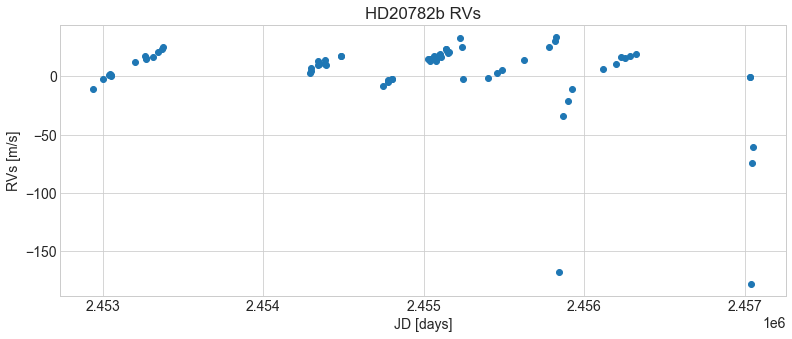

In [3]:
plt.figure(figsize=(13, 5))

plt.rcParams.update({'font.size': 14})

plt.errorbar(x=HD20782_rvs.times, y=HD20782_rvs.vals, yerr=HD20782_rvs.err, linestyle="None", fmt="o")

plt.title('HD20782b RVs')
plt.xlabel('JD [days]')
plt.ylabel('RVs [m/s]');

Note that the lowest RV measurements are not outliers, but an extreme value resulted from the planet's eccentric orbit.

See the below plot from J. O'Toole et al. (2016).

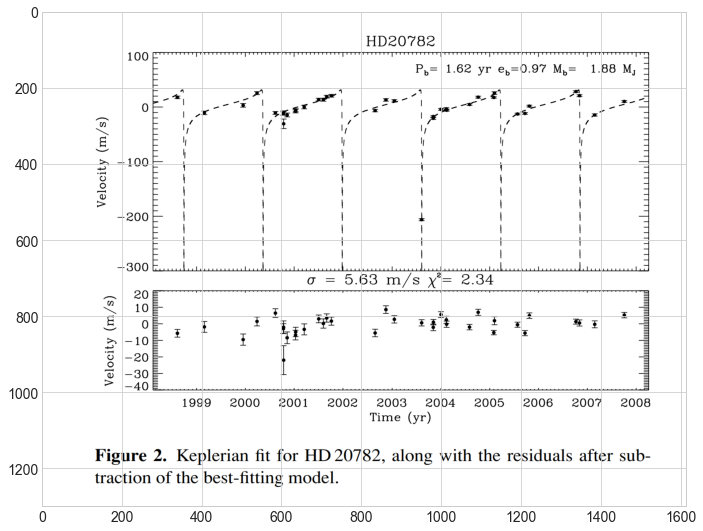

In [4]:
r = 0.7

plt.figure(figsize = (16.5 * r, 13 * r))

image = mpimg.imread("HD20782_plot.png")
plt.imshow(image, aspect='auto')
plt.show()

To phase-fold the RV data, we use the period $p$ = 597.065 from the following paper: EVIDENCE FOR REFLECTED LIGHT FROM THE MOST ECCENTRIC EXOPLANET KNOWN, by Kane et al. (2016). The paper [can be found here](https://iopscience.iop.org/article/10.3847/0004-637X/821/1/65).

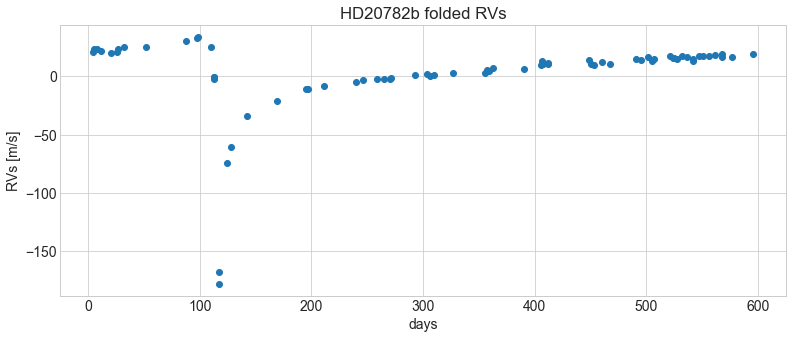

In [5]:
p = 597.065 # days

plt.figure(figsize=(13, 5))

plt.errorbar(x=[t % p for t in HD20782_rvs.times], y=HD20782_rvs.vals, yerr=HD20782_rvs.err, linestyle="None", fmt="o")

plt.title('HD20782b folded RVs')
plt.xlabel('days')
plt.ylabel('RVs [m/s]');

We will now use the following *calc_pdc* function from the *pdc_func* file to calculate the PDC.


In [6]:
from pdc_func import calc_pdc

In [7]:
freq = np.arange(0.001, 0.2, 0.0001)
times =  HD20782_rvs.times
rvs = HD20782_rvs.vals

In [8]:
A, a, pdc_power = calc_pdc(freq, times, rvs);

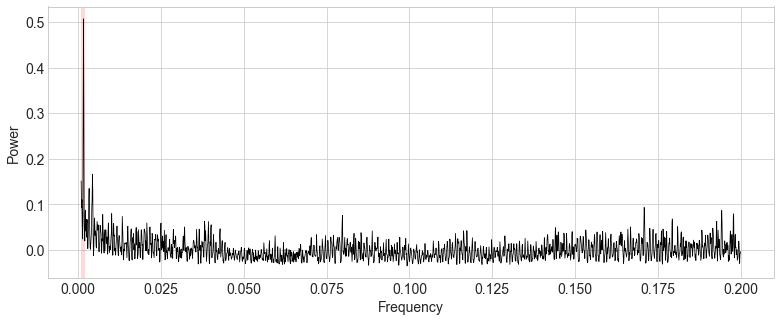

In [9]:
plt.figure(figsize=(13, 5))

plt.xlabel("Frequency")
plt.ylabel("Power")

plt.axvline(1/p, color='red', alpha=0.15, linewidth=4)
plt.plot(freq, pdc_power, color='black', linewidth=0.75);

The PDC periodogram can also account for measurement uncertainties (Binnenfeld et. al., in prep). 

This use case is demonstrated below:

In [10]:
freq = np.arange(0.001, 0.2, 0.0001)
times =  HD20782_rvs.times
rvs = HD20782_rvs.vals
errors = HD20782_rvs.err

In [11]:
A, a, pdc_power = calc_pdc(freq, times, rvs, errors);

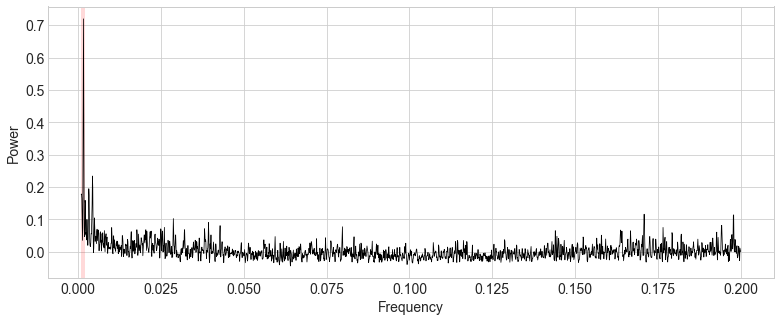

In [12]:
plt.figure(figsize=(13, 5))

plt.xlabel("Frequency")
plt.ylabel("Power")

plt.axvline(1/p, color='red', alpha=0.15, linewidth=4)
plt.plot(freq, pdc_power, color='black', linewidth=0.75);

We can use the method published in [Shen et. al. (2021)](https://pubmed.ncbi.nlm.nih.gov/35707063/) to assess the peak significance, the following way:

In [13]:
N = len(HD20782_rvs)

# Peak false alarm probability, without measurement uncertainties:
FAP_regular = chi2.sf(0.5 * N + 1, 1)

# Peak false alarm probability, with measurement uncertainties:
FAP_with_errs = chi2.sf(0.7 * N + 1, 1)

FAP_regular, FAP_with_errs

(1.1812924646610715e-09, 7.533853995203561e-13)

The significance of the peak is emphasized in the version of the periodogram accounting for measurement uncertainties. The change translates to a major decrease in the detection FAP, from $10^{-9}$ to $10^{-13}$.